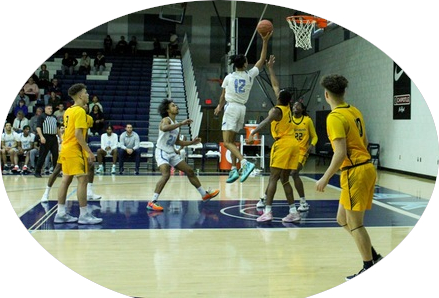</img>


# Project 3: March Madness

This project explores NCAA (mens) basketball statistics to predict finalist teams and estimate winners. (I tried to find a free source of womens NCAA data, but came up empty-handed, which is too bad since Caitlin Clark is probably the most famous of all players today.)

We'll look at some freely-available basic historic statistics about teams available for limited non-commercial use from https://kenpom.com. Specifically, we will:

1. assess teams likely to be champion (part 1)
2. try to estimate the teams that make the 2024 playoffs (part 2 below)

The specific objectives are less important than the ideas we use. Those ideas are applicable to large classes of problems in the real world.

We'll use tools from math and statitistics for optimizing things and solving nonlinear equations. And we'll learn how to turn complicated high-dimensional data into simpler low-dimensional problems using projection methods.

## Prologue: Program Environment and Data

We're using the "Jupyterlite" notebook environment for this project, but this time it runs completely in your browser and should work *much* better. And we're using a different language this time called "R"&mdash;but don't worry you don't need to learn a whole new language. Most of this project will consist of experimenting with tiny parts of algorithms that will be pretty familiar to you.

The data we'll work with is in *table* form&mdash;kind of like a spreadsheet, and different from a numeric matrix. In particular, some of the columns contain text data indicating things like team name and conference. Later we will process parts of the table into purely numeric and matrix form that you're already familiar with.

Our data table consists of a record of all the teams and their basic statistics from 2010 up until last week. The data include:

<table>
<tr><td>year<td>Tournament year
<tr><td>team<td>Team name
<tr><td>conf<td>Team conference
<tr><td>rank<td>A team overall ranking from somwhere (not sure where this comes from)
<tr><td>seed<td>A seed value greater than zero indicates the team made the playoffs that year (and the playoff ranking)
<tr><td>wins<td>Count of won games for the year
<tr><td>lost<td>Count of lost games for the year
<tr><td>offense<td>Average points scored per 100 possessions (adjusted a bit for opposing team skill)
<tr><td>defense<td>Average points allowed per 100 possessions (adjusted a bit for opposing team skill)
<tr><td>tempo<td>Average possessions per 40 minute interval
<tr><td>luck<td>A measure of schedule luck
<tr><td>avg_opponent_offense<td>Overall average opposing teams points scored per 100 possissions
<tr><td>avg_opponent_defense<td>Overall average opposing teams points allowed per 100 possessions
<tr><td>champion<td>1 if the team won the finals that year, zero otherwise (only one per year)
</table>

From 2010 until last week there are 5,285 rows of data like this to learn from. Let's load the data and take a look at the first few rows:

In [ ]:
# Load the data in and view the first few rows.
options(width=133)
weburl = gzcon(url("https://raw.githubusercontent.com/bwlewis/enr230-march-madness/main/madness.csv.gz"))
data = read.csv(textConnection(readLines(weburl)))
close(weburl)

head(data)
cat("\nNumber of rows in the data: ", nrow(data), "\n")
cat("Number of columns in the data: ", ncol(data), "\n")

  rank          team seed conf wins lost offence defence tempo   luck avg_opponent_offence avg_opponent_defence champion year
1    1          Duke    1  ACC   35    5   121.0    87.7  64.7  0.009                107.9                 96.4        1 2010
2    2        Kansas    1  B12   33    3   120.4    88.5  67.2  0.038                108.2                 98.7        0 2010
3    3      Syracuse    1   BE   30    5   118.5    90.9  68.7 -0.008                108.5                 99.8        0 2010
4    4      Kentucky    1  SEC   35    3   114.9    88.3  68.3  0.060                106.5                 99.5        0 2010
5    5 West Virginia    2   BE   31    7   117.2    91.7  62.6  0.057                110.0                 97.5        0 2010
6    6    Kansas St.    2  B12   29    8   116.1    90.6  69.4 -0.008                109.5                 97.5        0 2010

Number of rows in the data:  5275 
Number of columns in the data:  14 


## Interlude: Dealing with non-numeric data

Not all data you encounter in life will be numbers. For instance, we're going to want to use the 'conf' column (NCAA conference) in the above table, and it's a bunch of weird letter abbreviations. Yet, all the algorithms we know about like solving linear systems, least-squares problems, interpolation, and so on, require everything to be numeric!

What to do?  (Think about this for a minute and then read on.)

Let's make a simple example and just think about how to represent only the first four conferences above: ACC, B12, BE, and SEC using numbers.

One obvious idea is to just number them! Something like...
<table>
<tr><td><b>conf (original)</b><td><b>numeric conf</b>
<tr><td>ACC<td>1
<tr><td>B12<td>2
<tr><td>BE<td>3
<tr><td>SEC<td>4
</table>
This idea might kind-of work, but it has a big dis-advantage. The numbers imply a certan order on the 'conf' labels that might not mean anything. In other words, 4 is clearly bigger than 3. Does that mean that somehow SEC is bigger than BE? This might not make any sense, and worse, it could lead us to bad models and deceptive estimates.

Here is a different idea that encodes the labels above without imposing any artificial order on them:
<table>
<tr><td><b>conf (original)</b> <td><b>ACC conf</b> <td><b>B12 conf</b> <td><b>BE conf</b> <td><b>SEC conf</b>
<tr><td>ACC <td>1<td>0<td>0<td>0
<tr><td>B12 <td>0<td>1<td>0<td>0
<tr><td>BE <td>0<td>0<td>1<td>0
<tr><td>SEC <td>0<td>0<td>0<td>1
</table>
Now we've turned the list of conferences into a set of, in this example, four *new* columns; each with a zero or one. The ACC conf column contains a one if the team is in the ACC conference, or a zero otherwise. And so on. In some sense, each conference label is like a coordinate axis label.


The above approach turned a single column of labels into more than one column (dimension) of numerically-encoded values. Since there are 35 conference labels total in the data, this will significantly increase the ultimate dimension of the problem.


<hr>

### Exercise: Can you think of a more efficient way (resulting in lower dimension&mdash;that is, fewer columns) to encode the example above?

<hr>

## Part 1: Searching for Champions in the Shadows

This part explores the idea of "data clustering"&mdash;also called "unsupervised learning." We will use a subset of the data columns that only includes the conference, games won/lost, tempo and average offence/defence columns (in other words, **not** outcome columns like seed or champion). Then we will try to group data together based on the remaining columns to see if patterns emerge. In particular, we'd like to see if champion teams, or at least teams that made the playoffs, exhibit similar patterns. Finally, we'll highlight the data for the 2024 and look for teams close to previous champions.

### Turning the table data into a numeric matrix for modeling

We can manually, and tediously, encode each conference label into a set of numeric columns as outlined above. But the R language has a nice function with somewhat cryptic syntax that does that for us in one line (as well as adds a y-intercept model term):

In [ ]:
A = model.matrix(~ ., data=data[,c("conf", "wins", "lost", "offence", "defence", "tempo", "avg_opponent_offence", "avg_opponent_defence")])
cat("\nNumber of columns in the model matrix: ", ncol(A), "\n\n")


Number of columns in the model matrix:  42 



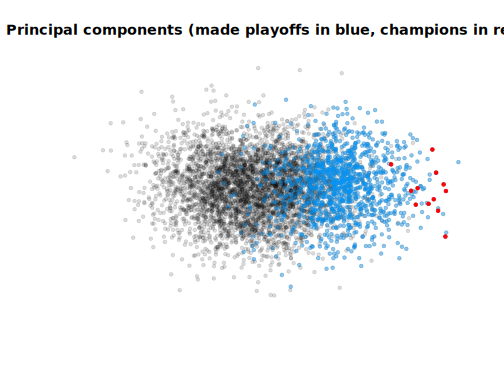

In [ ]:
C = scale(A, center = TRUE, scale = FALSE)
u = svd(C)$u[, 1:2]
plot(u, xlab = "", ylab = "", pch = 20, col = "#00000023", xaxt = "n", yaxt = "n", bty = "n")
title(main = "Principal components (made playoffs in blue, champions in red)")
points(u[data$seed > 0,], pch = 20, col = "#0099ff53")
points(u[data$champion > 0,], col = "#ff0000", pch = 20)

That's pretty cool! Each point in the plot above is a 2-d shadow of the data from one team over one year. The gray points are teams that did not make the playoffs that year. The blue ones, largely clustered together on the right, did make the playoffs. And the red ones, mostly on the far right, were  champions.

This pattern is based only on basic statistics about the teams: their conference, win/loss record, and offensive/defensive averages.

<hr>

### Excercise: Experiment with different subsets of columns above in the model matrix and see how your selection affects the plot.

<hr>

### Estimating teams that *might* become 2024 champion

Let's plot the data above again, but this time only highlighting the average of all previous champions (in red) and all the team data from 2024 so far (green). We will look for 2024 teams closest to the red points (the previous years champions).

This plot zooms in to the right side of the above plot to make the team labels easier to read.

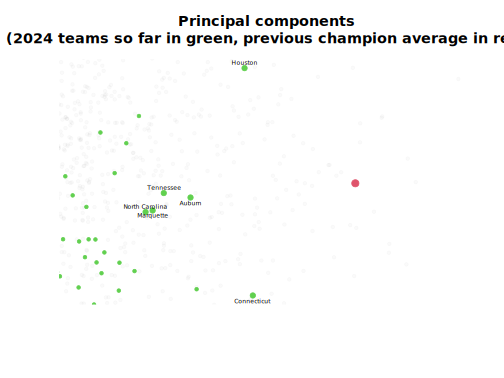

In [ ]:
i = data[["year"]] == 2024   # select 2024 team records so far
avg_champion = colMeans(u[data$champion > 0, ])   # average of all previous champions
# identify top 6 2024 teams with shadows closest to prior champions (so far, anyway)
closest = head(order(sqrt(apply(u[i,] - matrix(avg_champion, nrow=sum(i), ncol=2, byrow=TRUE), 1, crossprod))), 6)
pos = u[i,][closest,]
xlim = c(min(pos[,1] - 0.005), max(u[,1]))
ylim = range(pos[,2])

plot(u, xlab = "", ylab = "", pch = 20, col = "#00000005", xaxt = "n", yaxt = "n", bty = "n", xlim = xlim, ylim = ylim)
title(main = "Principal components\n(2024 teams so far in green, previous champion average in red)")
points(u[i,], pch = 20, col = 3)
points(rbind(avg_champion), col = 2, pch = 20, cex=2)

points(pos, cex = 1.5, pch = 20, col = 3)
pos[,2] = pos[,2]-0.0007*(-((-1)^seq(length(closest))))
text(pos, labels=data[["team"]][i][closest], cex=0.5)


Looking in the data shadows using principal components, we see that&mdash;so far, anyway, Houston, Connecticut, Tennessee, Auburn, North Carolina, and Marquette exhibit data behavior closest to all the previous champions from 2010 to 2023.

Out of that list, as of early February 2024 anyway, all of those teams are currently ranked in the top 10 except for Marquette (which is ranked 14th).

Does that mean one of those teams will be the champion? Who knows!? ButI'll bet that they all have  a good shot at it.

## Part 2: Picking Playoff Teams

Predicting a champion team is really hard. Many variables and luck affect the result, and there simply isn't a lot of data for a model to work with (at most one champion team per year, not much).

Picking which teams make the playoffs on the other hand, now there is a lot more data to work with. Every year, 68 teams are "seeded" in the NCAA playoffs making up March Madness. Each playoff team is assigned a "seed" number between 1 and 16 that determines their schedule and roughly corresponds to each teams performance (lower numbers mean better performance rankings).

This part of the project explores ideas for models that predict teams that will make the playoffs in a given year. The last year we have full data for is 2023. We'll develop models to predict which teams made the playoffs in 2023 to see how close we got. We can the apply the same model to the 2024 data and in a few weeks see how well that works!

### First Model: No Model

As a baseline, let's just take the to 68 ranked teams for 2023 and see how close those match the playoff teams.

In [ ]:
i = data[["year"]] == 2023  # Select 2023 team results
table(predicted = data[["rank"]][i] < 69, actual = data[["seed"]][i] > 0)

         actual
predicted FALSE TRUE
    FALSE   274   21
    TRUE     21   47


The small table above is sometimes called a "confusion matrix" and it helps evaluate the model. It says that if we picked teams only based on their ranking, then

- 47 (out of 68) of the teams that made the playoffs were correctly identified
- We incorrectly picked 21 teams that didn't make the playoffs
- We incorrectly ruled out 21 teams that *did* make the playoffs
- We correctly ruled out 274 teams that did not make the playoffs

A perfect model would result in a confusion matrix with nonzero entries along the diagonal above like this:
<pre>
         actual
predicted FALSE TRUE
    FALSE   295    0
    TRUE      0   68
</pre>
What we're shooting for is a simple model that can do better than the super-basic ranking baseline model above.

### Second Model: Simple Linear Least-Squares

We're trying to model whether a team gets assigned a seed value. Those values range from 1 to 16 and are, in principle, tied to team performance. What about setting up a simple linear model with the seed value as the model output as a linear function of the various historical team performance statistics? Something like:

$$
\textrm{seed} = x_0 + x_1 \textrm{wins} + x_2 \textrm{lost} + x_3 \textrm{offence} + \cdots
$$
or
$$
\textrm{seed} = A x
$$
for unknown model coefficient values in vector $x$ and model matrix $A$. The $A$ here will be basically the same model matrix as $A$ in the first part. This is just like the least-squares models we learned about in class (this one involves 42 dimensions).

The R `lm` function below solves the least-squares system in a numerically-stable way (more or less in the same way as Octave/MATLAB $x = A\backslash \textrm{seed}$). The `predict` function applies the solution coefficients to new data to yield a prediction. Finally the code prints a confusion matrix just like the one above.

There is one problem with the data: we want to model a "seed" value between 1 (best) and 16 (worst) for teams that make the playoffs. Teams that don't make the playoffs in the table above have their seed values set to zero, which is less than one. That's out of order for a linear fit! Ideally, teams that didn't make the playoffs would have a seed value *larger* (that is, worse) than 16. This would make much more sense when trying to run a line through those values. The first few lines of code below set the seed values for teams that didn't make the playoffs to 100. You can experiment with different values below to see how that affects the resulting model.

In [ ]:
# Adjust seed value for linear least squares fit
k = data[["seed"]] == 0
data[["seed"]][k] = 100    # experiment with different values > 16 here...

i = data[["year"]] < 2023  # select training data to be all years before 2023
ols = lm(seed ~ conf + wins + lost + offence + defence + tempo + avg_opponent_offence + avg_opponent_defence, data=data[i,])

j = data[["year"]] == 2023  # select testing data to be year = 2023
p = predict(ols, newdata = data[j,])
table(predicted = p < sort(p)[69], actual = data[["seed"]][j] < 17)   # only 68 teams make the playoffs, take the top 68


         actual
predicted FALSE TRUE
    FALSE   283   12
    TRUE     12   56


Much better! The simple least-squares approach improved on the baseline ranking method, at least for 2023 data, by getting an additional 9 playoff teams correct.

### Playoff predictions for 2024

Let's apply this model to the current (as of early February, 2024) data to make a prediction for playoff teams this year, based on their stats up to this point (early February):

In [ ]:
j = data[["year"]] == 2024   # select testing data to be this year
p = predict(ols, newdata = data[j, ])
print(data[["team"]][j][p < sort(p)[69]])

 [1] "Houston"          "Purdue"           "Connecticut"      "Auburn"           "Arizona"          "Tennessee"       
 [7] "Alabama"          "Illinois"         "Iowa St."         "North Carolina"   "Marquette"        "Duke"            
[13] "Baylor"           "BYU"              "Michigan St."     "Creighton"        "San Diego St."    "Wisconsin"       
[19] "Kansas"           "Saint Mary's"     "Dayton"           "Texas Tech"       "New Mexico"       "Texas"           
[25] "Kentucky"         "Clemson"          "Florida"          "Villanova"        "Oklahoma"         "Mississippi St." 
[31] "Florida Atlantic" "TCU"              "Cincinnati"       "Colorado St."     "Colorado"         "Washington St."  
[37] "Utah St."         "St. John's"       "Texas A&M"        "Xavier"           "Utah"             "Nevada"          
[43] "Indiana St."      "Butler"           "Nebraska"         "Northwestern"     "South Carolina"   "Boise St."       
[49] "Virginia"         "Providence"       "Gran

### Interlude: Model Training and Testing Sets

The pattern used above is a very important one in the subject of *machine learning*: train a model using a subset of the known data, then test the model on the held-out part. Many formal approaches to this basic idea exist, including *generalized cross-validation* which you may encounter out in the real world. Cross-validation re-runs the modeling process over and over with different training and testing subsets. It's a great way to make sure that a model works reasonably well against lots of typical data and doesn't surprise you with weird results. Cross-validation is also a good idea when comparing or tuning models.

<hr>

### Exercise: Re-run the above simple least-squares model training it on years 2010&mdash;2021 and 2023 and testing it on year 2022 data. How do the predicted results compare to the ones for 2023?

Hint: Here is one R-language way to select years 2010&mdash;2021 *and* 2023 (the vertical bar means logical 'or'):

<pre>
i = data[["year"]] < 2022 | data[["year"]] == 2023
</pre>

<hr>

### A Third Model: Logistic Regression

Whether a team makes the playoffs or not is a binary event: it either happens or it doesn't. We can represent binary things numerically with, for instance 0 and 1: 0 if the team didn't make the playoffs, 1 if it did. Often, we're interested in producing a model with output indicating the probability of making the playoffs, that is the output is a number in between zero and one, trained on the historical binary data.

You *could* try to build a linear model for data with output in the interval $[0,1]$ but there is a problem: lines either are horizontal and have exactly one $y$-value, or they have a nonzero slope and go through *every* $y$-value.  An output that is constrained to the interval $[0,1]$ is poorly modeled by a line!

What can we do about that? There is a famous function called the *logistic function* (there are others too) that takes as input any real number and returns an output in the interval $[0,1]$:

$$
f(x) = \frac{1}{1 + \exp(-x)}.
$$

The linear least squares problem that we learned about in class and used above looks like
$$
\min_x\|A x - y\|
$$
for observed data $y$ and unknown coefficients $x$ (the $x$ in the least-squares model above has 42 entries). A given prediction using that model, $Ax$ is linear and its values unconstrained. Now consider a model that looks like this:
$$
\min_x\|g(A x) - y\|
$$
This model output **is** constrained to the interval $[0,1]$ by the logistic function $g$ above! That's great&mdash;just what we need! One big catch, however, is that this is no longer a *linear* least-squares problem, but instead a *nonlinear* one.

### Interlude: Nonlinear Function Root-Finding with Newton's Method

Let's think back to calculus class. Say you've got a continuous, differentiable function $g(x):\mathbb{R}\rightarrow\mathbb{R}$ and you'd like to find $x$ values where $g(x) = 0$. Let's say you start with a guess $x_0$ as shown in this picture:

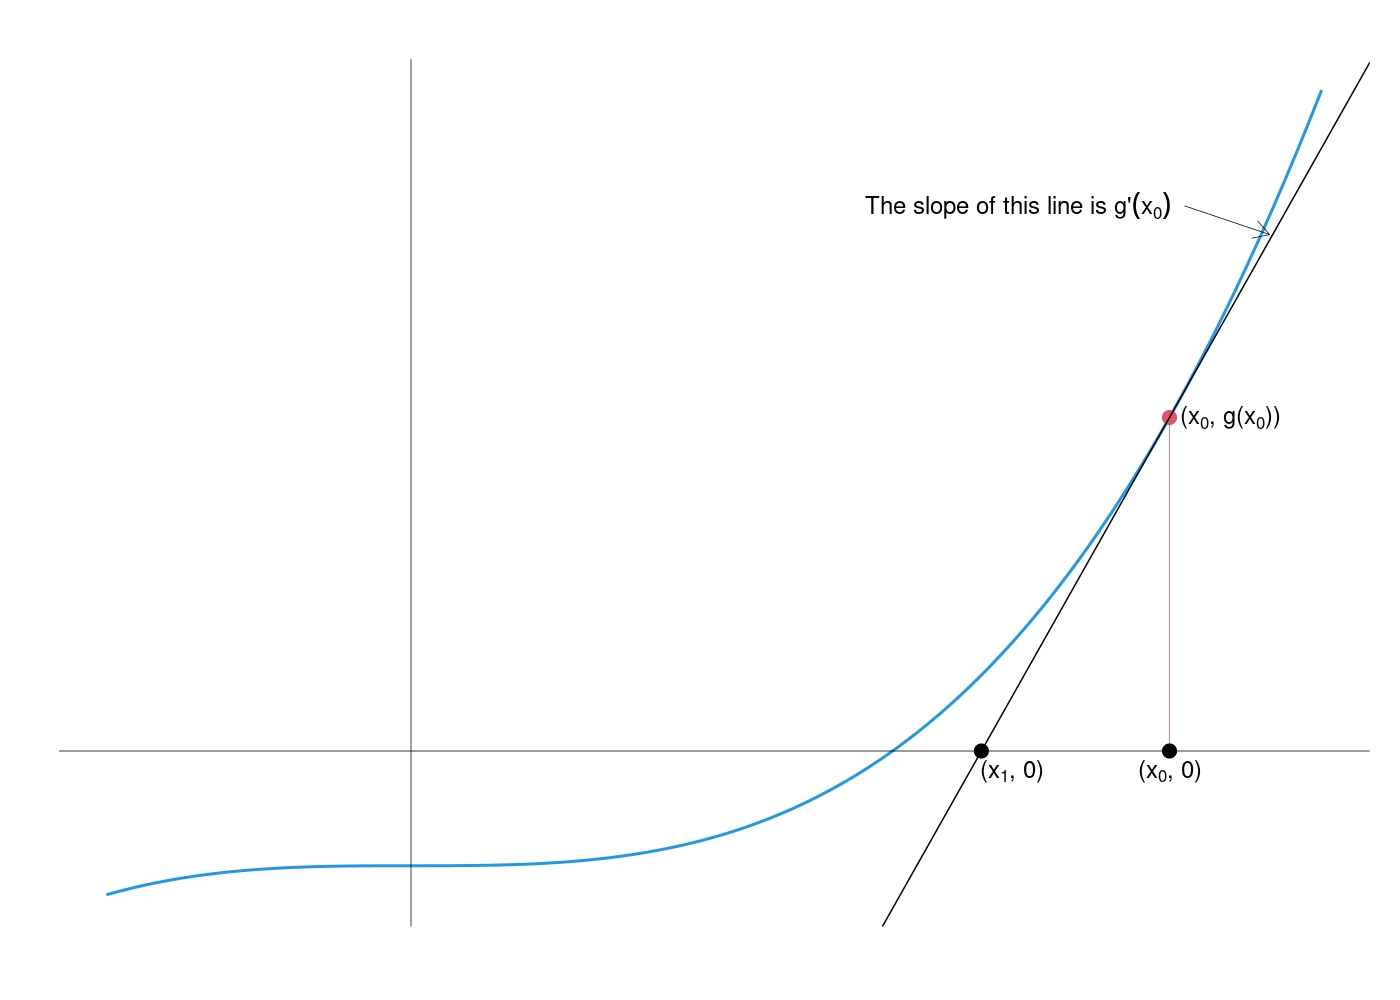</img>

The idea behind Newton's method is to approximate the function at your initial guess by a line with the same slope as the tangent line to the function at the guess and see where that line hits the x-axis (the point $x_1$ in the picture):

$$
\textrm{slope at } x_0  = g'(x_0) = \frac{g(x_0) - 0}{x_0 - x_1}
$$
so, sovling for $x_1$:
$$
x_1 = x_0 - \frac{g(x_0)}{g'(x_0)}.
$$
This gives us the next guess for the zero of the function $g$. Plug that in and repeat the process. This is Newton's method. (There is *a lot* more to Newton's method; it's a truly astounding algorithm!)

Now, the nonlinear least squares objective function above,
$$
q(x) = \min_x\|g(Ax) - y\|,
$$
is a real-valued function just like in the Newton's method example. However, it's input is a vector, not a real number! In Calc 3 you will learn that a version of Newton's method applies to functions like this.

That means that we can use Newton's method, or something like it, to solve the logistic-function transformed nonlinear least squares problem above. Except for one small (large if you are a statistician) detail, this is what statisticians based *logistic regression* on. Data are transformed by a logistic function and a nonlinear least-squares problem is solved.

We can apply logistic regression to the March Madness problem using the R language in a way that looks almost exactly like the ordinary least-squares approach above...

In [ ]:
# Cook up a binary variable 'in_playoffs' indicating whether each team made the playoffs in each year:
data[["in_playoffs"]] = (data[["seed"]] <= 16)

# Set up a nonlinear least squares statistical model based on the logistic link function.
# The R-language syntax here is nearly identical to the ordinary least squares approach above. Nice!
model_vars = in_playoffs ~ conf + wins + lost + offence + defence + tempo + avg_opponent_offence + avg_opponent_defence
logistic = glm(model_vars, data=data[i,], family = binomial())

j = data[["year"]] == 2023
p = predict(logistic, newdata=data[j,], type = "response")
print(table(predicted = p > sort(p, decreasing=TRUE)[69], actual = data[["seed"]][j] < 17))

         actual
predicted FALSE TRUE
    FALSE   284   11
    TRUE     11   57


Wow. All that work and only a marginal improvement over the simple least squares approach above. The logistic method correctly predicted 57 out of 68 teams in the playoffs for 2023 (compared to 56 for ordinary least squares).

I'm guessing that one reason prediction methods like this can only go so far is that there is a fair amount of discretion and even randomness in the selection of high-seed-value teams in each playoff season. It's just really noisy data.

Still, the logistic and least-squares methods do a better job of predicting playoff teams than generic team rankings (wherever those numbers come from)&mdash;at least for 2023.